# Customer Retention Analysis
Business can thrive and dive depending upon how happy your customers are, how loyal they are, and how willing they are to keep buying your services. We will disciuss how Loyal customers are worth up to 10 times as much their first purchase and it is 6 to 7 times more expensive to land a new customer than to keep a current one. 

This project is aimed to

1. Understand the causes and/or scenarios causing attrition of customers 
2. Understand acquisition relation with tenure and compare it with retention 
3. Provide a predictive model that ranks the customers 
4. Learn the factors which are strongly correlated with churn rate 
5. Make recommendations to minimize the revenue loss 


## Dataset
In this project [Telco Customer Churn dataset](https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv) is used to study the customer behavior to develop focused customer retention programs.

This dataset has 7043 samples and 21 features, the features includes 

1. Customers who left within the last month – the column is called Churn
2. Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
3. Customer account information – how long they’ve been a customer, contract, payment method
4. Costs in paperless billing, monthly charges and total charges
5. Demographic info about customers – gender, age range, and if they have partners and dependents

## Project Scope

1. Which variables influences if the client will leave? 
2. What are the most important variables to look?
3. Which clients have the highest chance of leaving?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import classification_report
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import pickle

## Data Ingestion

In [2]:
#Loading the data
df = pd.read_excel("Customer-Churn-Dataset.xls")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape

(7043, 21)

* Replace empty spaces (if any) with NA values.

In [4]:
#Replacing empty spaces with Null values
df = df.replace(r'^\s+$', np.nan, regex=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Check for Null Values
df.apply(lambda x: sum(x.isnull()), axis=0)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

* Dropping few NaN rows that has Null values

In [7]:
# Dropping NA values
df = df.dropna()

## Visualizing the Missingness of Data

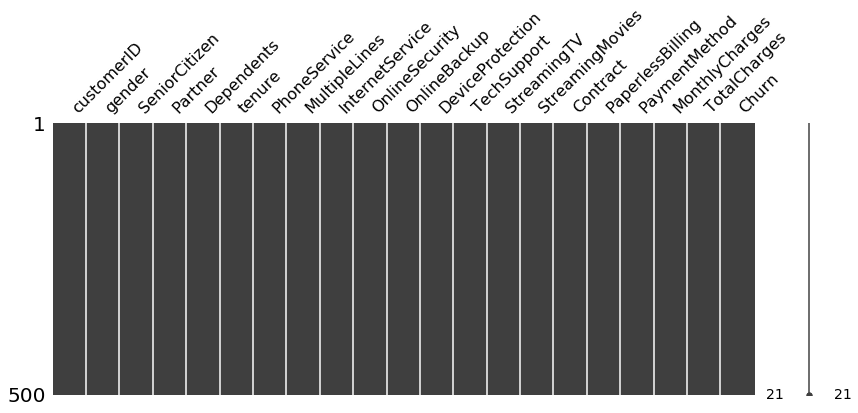

In [8]:
# Matrix of missingness of the data
missingness=msno.matrix(df.sample(500), figsize=(14, 5), width_ratios=(14, 1));

* 'CustomerId' is specific and unique to every row and it doesn’t help to predict if the client is going to Churn. Deleting the CustomerID.

In [9]:
# Deleting the custumerID column
del df["customerID"]

In [10]:
Cost_retention = df["TotalCharges"] 
del df["TotalCharges"]

* Force change of 'dtypes' to numeric and categorical.

In [11]:
all_columns_list = df.columns.tolist()
numerical_columns_list = ['tenure','MonthlyCharges']
categorical_columns_list = [e for e in all_columns_list if e not in numerical_columns_list]
for index in categorical_columns_list:
    df[index] = pd.Categorical(df[index])
for index in numerical_columns_list:
    df[index] = pd.to_numeric(df[index])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod     7032 n

# Exploratory Data Analysis

## Splitting the Dataset into Numeric and Objects to facilitate the Analysis

In [13]:
# Splitting data according to datatypes
num = ['float64', 'int64']
num_df = df.select_dtypes(include=num)
obj_df = df.select_dtypes(exclude=num)

In [14]:
num_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.00,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.35,89.8625,118.75


In [15]:
obj_df.describe().T

,count,unique,top,freq
gender,7032,2,Male,3549
SeniorCitizen,7032,2,0,5890
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087
DeviceProtection,7032,3,No,3094


In [16]:
df.groupby('Churn').size()

Churn
No     5163
Yes    1869
dtype: int64

* Churn Percentage

In [17]:
df['Churn'].value_counts(normalize = True) * 100

No     73.421502
Yes    26.578498
Name: Churn, dtype: float64

## Univariate Distribution
>Considers Numeric Variables

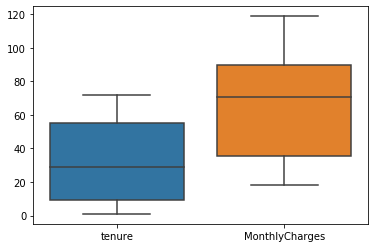

In [18]:
sns.boxplot(data = num_df);

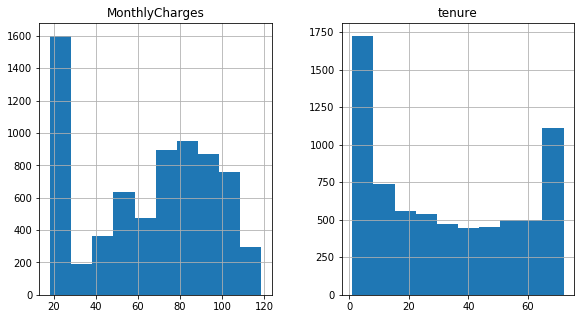

In [19]:
# histogram plots
num_df.hist(layout=(1,3), figsize=(15,5))
plt.plot();

* The above two plots shows that the numeric variables are not normally distributed.
* Further, checking how they are related to the target variable.

* Adding 'Churn' variable in numeric dataset

In [20]:
num_df = pd.concat([num_df,df["Churn"]],axis=1)

In [21]:
num_df.head()

,tenure,MonthlyCharges,Churn
0,1,29.85,No
1,34,56.95,No
2,2,53.85,Yes
3,45,42.30,No
4,2,70.70,Yes


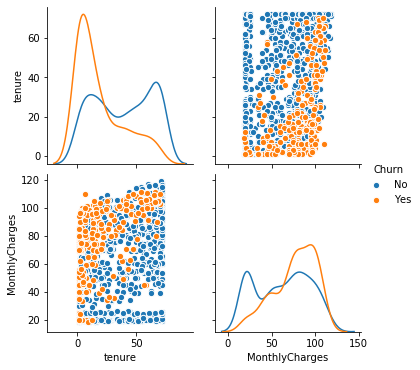

In [22]:
#Plotting pair plot to identify relationship between 'Churn' and other variables
g = sns.PairGrid(num_df.sample(n=1000), hue="Churn")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.map_diag(sns.kdeplot)
g = g.add_legend()

* From the above plots 'tenure' and 'MonthlyCharges' are good predictors of the 'Churn' variable

## Bivariate Distribution
>Bivariate Distribution helps to identify how each numeric variable is distributed with respect to target variable 'Churn'

Process:
* Use violin plots to decide bins of the numerical variables that we are going to use.
* Divide the numerical variables into bins and plot separately to identify the low and high Churn areas.

Plotting for 'tenure' variable with respect to target variable 'Churn'

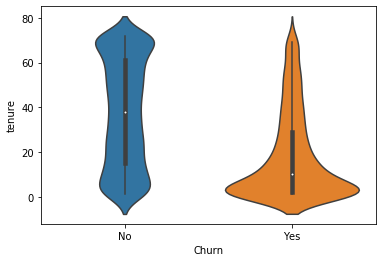

In [23]:
sns.violinplot(x="Churn", y="tenure", data=num_df);

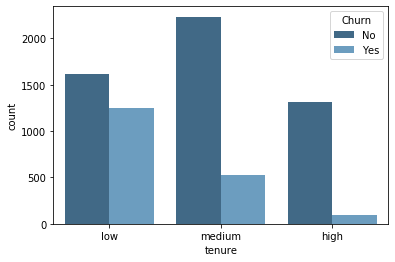

In [24]:
#Creating bins and plotting Countplot for 'tenure'
tenure_bins=pd.cut(num_df["tenure"], bins=[0,20,60,80], labels=['low','medium','high'])
sns.countplot(x=tenure_bins, hue="Churn", data=num_df, palette="Blues_d");

Plotting for 'MonthlyCharges' variable with respect to target variable 'Churn'

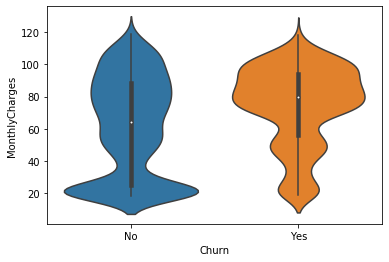

In [25]:
sns.violinplot(x="Churn", y="MonthlyCharges", data=num_df);

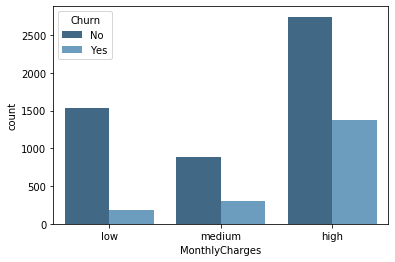

In [26]:
#Creating bins and plotting Countplot for 'MonthlyCharges'
MonthlyCharges_bins=pd.cut(num_df["MonthlyCharges"], bins=[0,35,60,130], labels=['low','medium','high'])
sns.countplot(x=MonthlyCharges_bins, hue="Churn", data=num_df, palette="Blues_d");

**Inference:**
The numerical variables are divided in 3 bins according to the violin plot trying to separate them in a way to distinguish the low churn rate areas from the high churn rate areas, justified by count plots showing how distribution is different in each bin.

**From the above plots following can be deducted:**
    1. Less than a year tenure category has highest churn
    2. Customers paying high Monthly charges tends to churn more
    3. 2 to 5 years tenure category results in highest revenue loss
    4. There is not much variation in medium bin which means customer remain loyal as they cross a year

## Numerical vs Categorical Variables
>Plot numeric and categorical variables to explore the dependency of variables on each other.

Since there are too many categorical variables , splitting them into 3 different sets and then plotting each set with the numerical variables

C:\Users\Harsh\anaconda3\lib\site-packages\seaborn\axisgrid.py:1264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


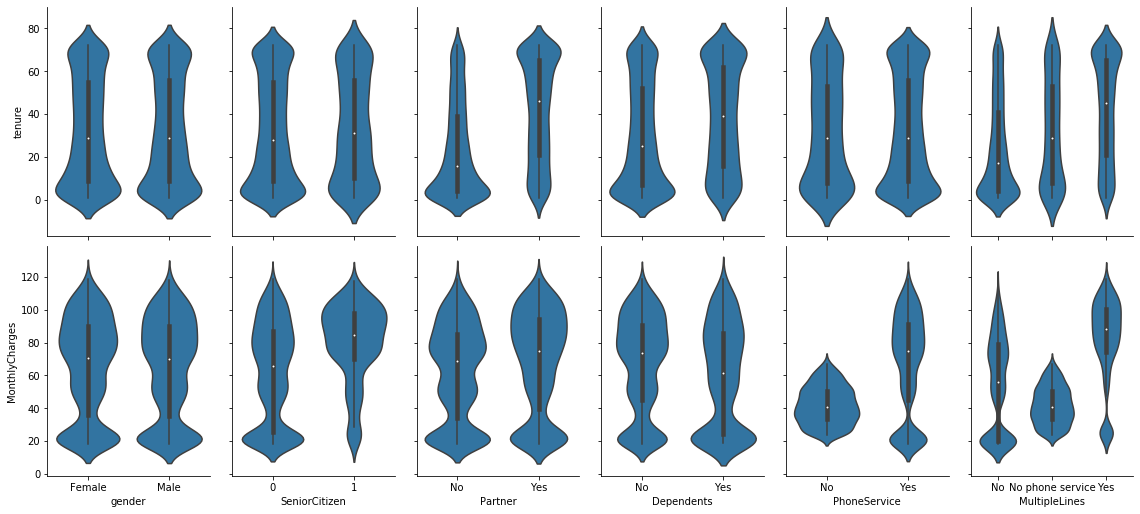

In [27]:
# Splitting the first set and plotting against numeric variables
g = sns.PairGrid(df, x_vars=obj_df.columns[0:6].values,
    y_vars=num_df.columns[0:2].values, aspect=.75, size=3.5)
g.map(sns.violinplot);

C:\Users\Harsh\anaconda3\lib\site-packages\seaborn\axisgrid.py:1264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


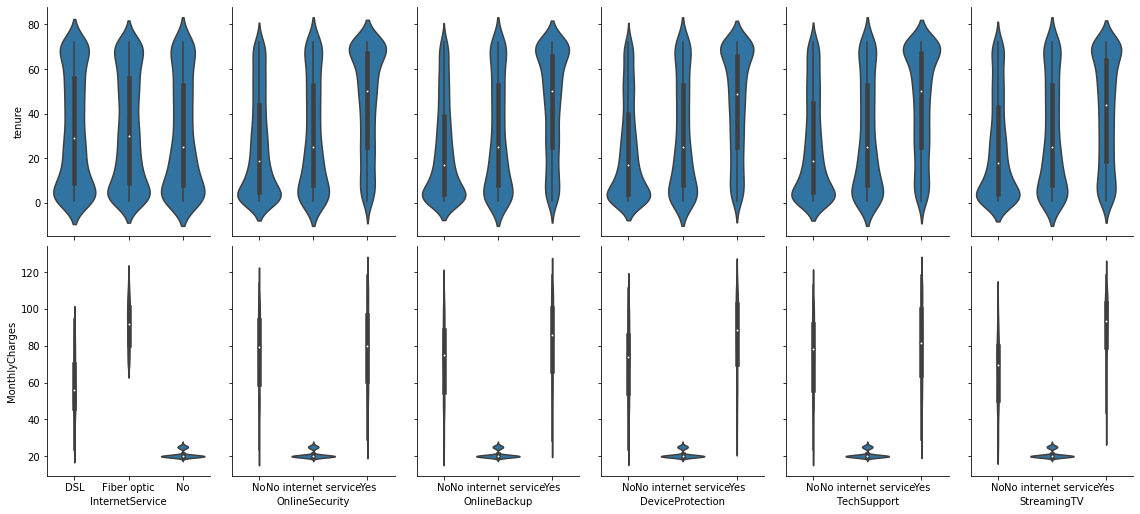

In [28]:
# Splitting the second set and plotting against numeric variables
g = sns.PairGrid(df, x_vars=obj_df.columns[6:12].values,
    y_vars=num_df.columns[0:2].values, aspect=.75, size=3.5)
g.map(sns.violinplot);

C:\Users\Harsh\anaconda3\lib\site-packages\seaborn\axisgrid.py:1264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


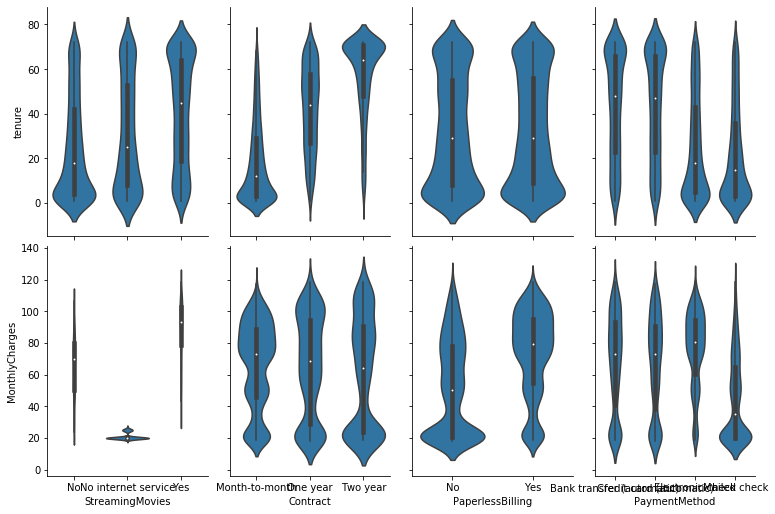

In [29]:
# Splitting the third set and plotting against numeric variables
g = sns.PairGrid(df, x_vars=obj_df.columns[12:16].values,
    y_vars=num_df.columns[0:2].values, aspect=.75, size=3.5)
g.map(sns.violinplot);

**From the above plots following can be deduced:**
    1. Customers with Eletronic or Mailed check payment method have a lower tenure
    2. Variable like gender does not influence tenure and monthly payment 
    3. The importance of Fibre optic service on monthly revenue is very clear
    
> * The above conclusions from the plots are very important to design the campaigns for the firm to focus on the specific areas which needs to be enhanced in terms of service quality or affordable price to reduce the customer's churn rate. 

### Acquisition vs Retention 

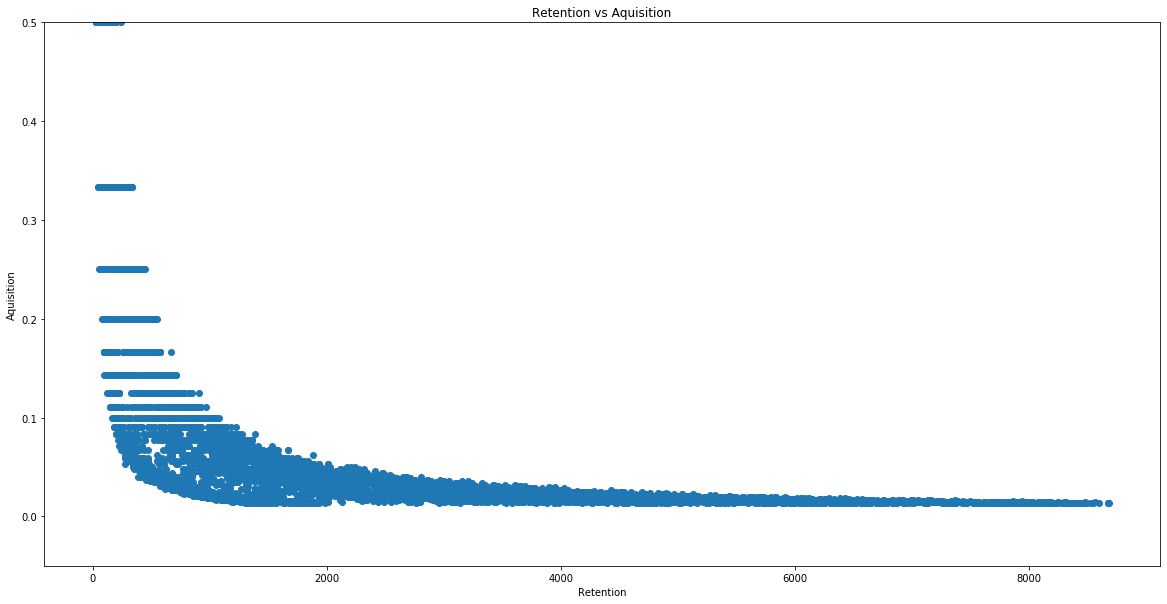

In [30]:
plt.figure(figsize = (20,10))
plt.scatter(Cost_retention,1./df.tenure)
plt.ylim(-0.05,0.5)
plt.xlabel('Retention')
plt.ylabel('Aquisition')
plt.title('Retention vs Aquisition')
plt.show()

1. This Graph clearly stats that Retention is much less costly for higher Tenure
2. Also note that less data points exist on higher retention side which states that acquisition cost of possibly lower teneur customer is more than that for customer with possibly higher teneur 

## Categorical Variables
>Plotting each variable as a bar plot.

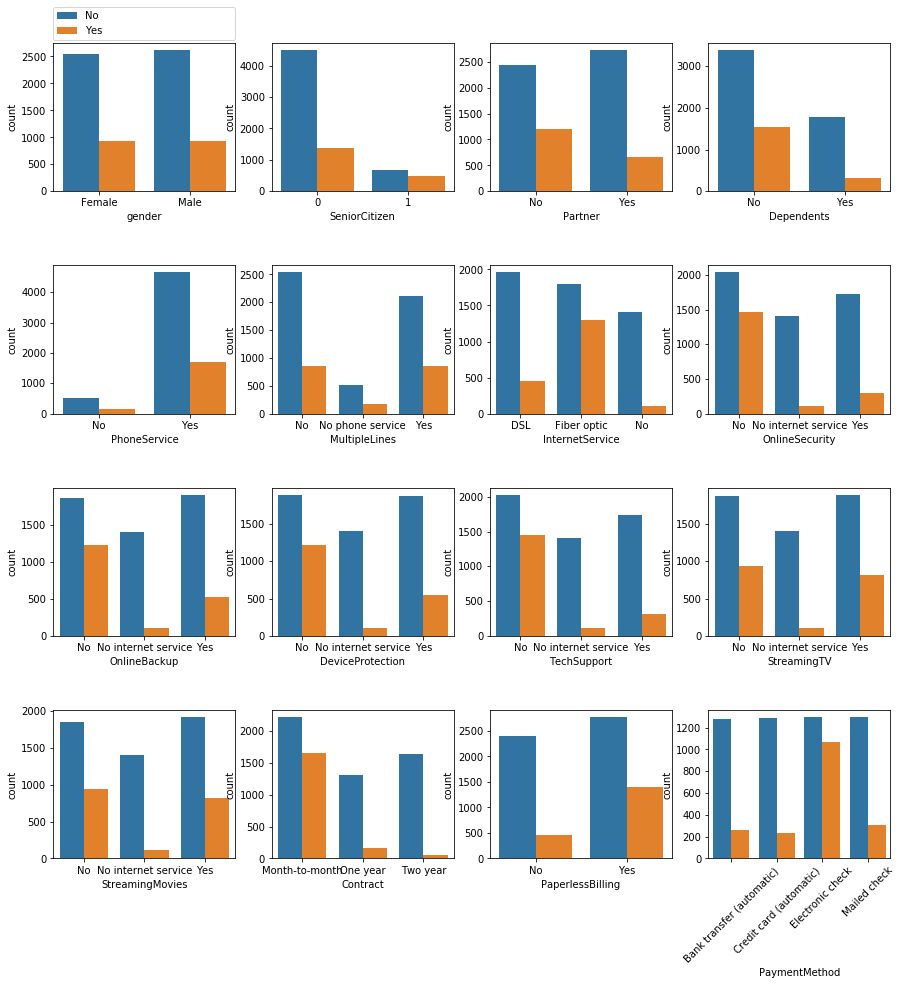

In [31]:
fig,ax =plt.subplots(4,4,figsize=(15,15))
fig.subplots_adjust(hspace=.5)
for i in range(0,16):
    g = sns.countplot(x=obj_df.iloc[:,i], hue=obj_df["Churn"], ax=ax[divmod(i,4)])
    g.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0.) if i==0 else g.legend_.remove()
for tick in ax[3,3].get_xticklabels():
    tick.set_rotation(45)

The above plots gives a better picture of variables that are more important such as
    1. Month-to-month contract is a strong indicator if the client might leave
    2. Electronic check payment method also provide clear view to the client stability
    3. On the other hand Senior citizen is a good predictor but only represents a small amount of clients
    
* So focus is on the variables that delivers best results in terms of Churn of company clients

# Feature Engineering
>Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work.

In the dataset:
    
* There are columns with a scope of transformation, like SeniorCitizen
* There is no null data in the dataset as it has been removed intially
* Variable like CustomerId is redundant as it does not help in prediction of the churn of the clients, already dropped
* As per Numerical variable analysis TotalCharges and Monthly Charges are correlated and MothlyCharges is approximately equal to product of MonthlyCharges and tenure which makes MonthlyCharges redundant, already dropped




In [32]:
#Converting SeniorCitizen variable into categorical and mapping values of Yes & No to 1 & 0 respectively
df['SeniorCitizen'] = df.SeniorCitizen.map({0:'No', 1:'Yes'})

Process Followed:
* Merge the numerical variables bins into dataframe
* Concatenate with the categorical variables
* Transform the categorical variables into binary vectors
* Split the dataset into training and testing

In [33]:
# Saving numeric variable bins into a dataframe
bins = pd.DataFrame([tenure_bins, MonthlyCharges_bins]).T

In [34]:
# Concatenate bins with object variables
transformed_df = pd.concat([bins,obj_df],axis=1)

In [35]:
transformed_df.head()

,tenure,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,low,low,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,medium,medium,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,low,medium,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,medium,medium,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,low,high,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


## Dummy Variables

* Dummy variables are used as devices to sort data into mutually exclusive categories
* Converting the categorial variables into dummy variables (extensive categories) to indicate the occurence of major prediction values

In [36]:
dummy_columns = [e for e in transformed_df.columns if e != 'Churn']
# Creating dataframe of dummy variables
df_dummies = pd.get_dummies(data=transformed_df, columns=dummy_columns)

In [37]:
df_dummies.head()

,Churn,tenure_high,tenure_low,tenure_medium,MonthlyCharges_high,MonthlyCharges_low,MonthlyCharges_medium,gender_Female,gender_Male,SeniorCitizen_0,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,No,0,1,0,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1,No,0,0,1,0,0,1,0,1,1,...,0,0,1,0,1,0,0,0,0,1
2,Yes,0,1,0,0,0,1,0,1,1,...,0,1,0,0,0,1,0,0,0,1
3,No,0,0,1,0,0,1,0,1,1,...,0,0,1,0,1,0,1,0,0,0
4,Yes,0,1,0,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [38]:
# Splitting dependent and independent variables for extracting important features
df_dummies_features = df_dummies.drop(["Churn"], axis=1).columns
X_all = df_dummies[df_dummies_features]
y_all = df_dummies["Churn"]

## Feature Selection using BORUTA

In [39]:
# Change X and y to its values
X_boruta = X_all.values
y_boruta = y_all.values

# Define random forest classifier, with utilising all cores and sampling in proportion to y labels
rfc = RandomForestClassifier(n_jobs = -1)
 
# Define Boruta feature selection method
feature_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)
 
# Find all relevant features
feature_selector.fit(X_boruta, y_boruta)

#Transposing dataframe for ranking and Creating Features Dataframe
all_feature = df_dummies.drop(['Churn'],axis=1).columns.tolist()
df_features_rank = pd.DataFrame(index = all_feature)

# Check ranking of features
df_features_rank['Boruta_Rank'] = feature_selector.ranking_
df_features_rank

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	37
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	37
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	37
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	4
Rejected: 	37
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	38
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	38
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	38
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	38
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	39
I

,Boruta_Rank
tenure_high,6
tenure_low,1
tenure_medium,1
MonthlyCharges_high,30
MonthlyCharges_low,38
MonthlyCharges_medium,31
gender_Female,10
gender_Male,10
SeniorCitizen_0,20
SeniorCitizen_1,18


In [40]:
# Adding a variable 'Feature' in the dataframe
df_features_rank['Feature']=  df_features_rank.index

In [41]:
# Sort the dataframe as per Rank
df_features_rank = df_features_rank.sort_values('Boruta_Rank')

C:\Users\Harsh\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Harsh\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


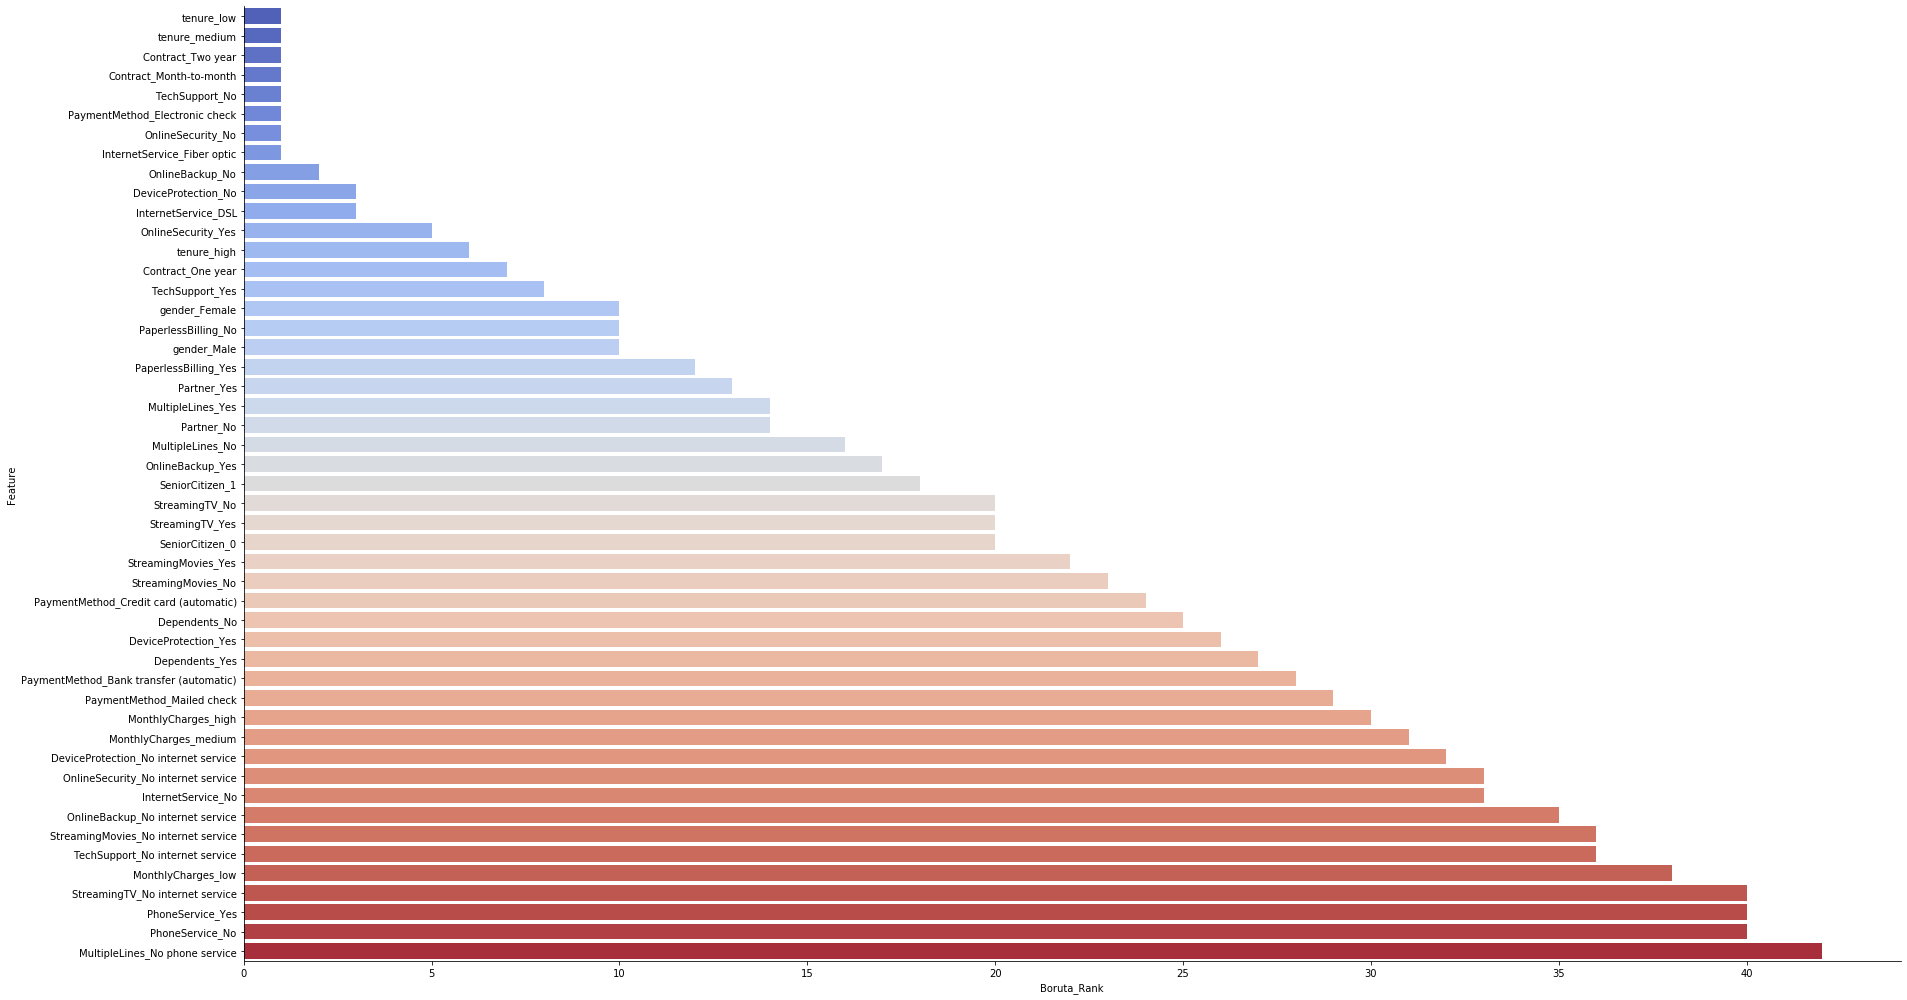

<Figure size 1080x1152 with 0 Axes>

In [42]:
# Plot the ranking of the features
sns.factorplot(x='Boruta_Rank', y='Feature', data = df_features_rank, kind="bar", size=14, aspect=1.9, palette='coolwarm');
plt.figure(figsize=(15,16));

### Defining Hyperparameters
Based on Feture selection using Boruta following are the top selected features:
* tenure_low
* tenure_medium
* Contract_Month-to-month
* TechSupport_No
* PaymentMethod_Electronic check
* OnlineSecurity_No
* InternetService_Fiber optic
* OnlineBackup_No
* Contract_Two year

In [43]:
# Exctracting only top 2 ranked features
df_top2_ranked_feature = df_features_rank.loc[df_features_rank['Boruta_Rank'].isin([1,2])]
df_top2_ranked_feature

,Boruta_Rank,Feature
tenure_low,1,tenure_low
tenure_medium,1,tenure_medium
Contract_Two year,1,Contract_Two year
Contract_Month-to-month,1,Contract_Month-to-month
TechSupport_No,1,TechSupport_No
PaymentMethod_Electronic check,1,PaymentMethod_Electronic check
OnlineSecurity_No,1,OnlineSecurity_No
InternetService_Fiber optic,1,InternetService_Fiber optic
OnlineBackup_No,2,OnlineBackup_No


In [44]:
# Selecting important featutres
selected_features = df_top2_ranked_feature.index

In [45]:
selected_features

Index(['tenure_low', 'tenure_medium', 'Contract_Two year',
       'Contract_Month-to-month', 'TechSupport_No',
       'PaymentMethod_Electronic check', 'OnlineSecurity_No',
       'InternetService_Fiber optic', 'OnlineBackup_No'],
      dtype='object')

In [46]:
#Exporting new dataset with selected columns
X_selected = df_dummies[selected_features]
y_selected = df_dummies["Churn"]
X_selected.head()

,tenure_low,tenure_medium,Contract_Two year,Contract_Month-to-month,TechSupport_No,PaymentMethod_Electronic check,OnlineSecurity_No,InternetService_Fiber optic,OnlineBackup_No
0,1,0,0,1,1,1,1,0,0
1,0,1,0,0,1,0,0,0,1
2,1,0,0,1,1,0,0,0,0
3,0,1,0,0,0,0,0,0,1
4,1,0,0,1,1,1,1,1,1


# Machine Learning: Training Models

### Split Training and Testing Dataset

Splitting to 80% training and 20% testing

In [47]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_selected, y_selected, test_size=0.20, random_state=7)

Following models are considered for prediction:
* Logistic Regression
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier

To compare different models, using Kfold method and know the best model to predict the test data

In [48]:
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

C:\Users\Harsh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR: 0.798759 (0.013001)


C:\Users\Harsh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.767464 (0.033844)
CART: 0.796447 (0.012383)


C:\Users\Harsh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\Harsh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.796980 (0.013359)


Prdeicting using all models on test dataset


In [49]:
# Make predictions on test dataset
models = []
accuracy_list = []
trained_models = {}
models.append(('LogisticRegression', LogisticRegression()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))

for name, model in models:
    model.fit(X_train, y_train)
    trained_models[name] = model
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    accuracy_list.append((name,acc))

In [50]:
#Creating a dataframe for the models metrics
models_metrics = pd.DataFrame(accuracy_list, columns=["Model", "Accuracy"]) 

In [51]:
models_metrics['Model_Rank'] = models_metrics['Accuracy'].rank(ascending=False, method='first')
models_metrics

,Model,Accuracy,Model_Rank
0,LogisticRegression,0.788913,1.0
1,KNeighborsClassifier,0.778252,4.0
2,DecisionTreeClassifier,0.783937,2.0
3,RandomForestClassifier,0.783227,3.0


In [52]:
# Store the result into csv
models_metrics.to_csv('metrics_score.csv', index=False)

**The above metrics shows that Logistic Regression model is the best model and have good overall prediction.**

# Pickle
>Pickle is the standard way of serializing objects in Python. Pickle operation serializes machine learning models and save the serialized format to a file. Later it can be loaded and deserialized to make new predictions, maintaining persistency

In [53]:
# Rank Dictionary
rank_dict = pd.Series(models_metrics.Model_Rank.values, index=models_metrics.Model.values).to_dict()

In [54]:
rank_dict

{'LogisticRegression': 1.0,
 'KNeighborsClassifier': 4.0,
 'DecisionTreeClassifier': 2.0,
 'RandomForestClassifier': 3.0}

In [55]:
# Dictionary with Key:Value pair as Rank:[model, model_name]
trained_models_with_rank = {}
for key, value in rank_dict.items():
    trained_models_with_rank[rank_dict[key]] = [value1 for key1, value1 in trained_models.items() if key == key1]
    trained_models_with_rank[rank_dict[key]].append(key)

In [56]:
trained_models_with_rank

{1.0: [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False),
  'LogisticRegression'],
 4.0: [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                       weights='uniform'),
  'KNeighborsClassifier'],
 2.0: [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=None, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                        

In [57]:
# Save the model to disk
filename = 'pickled_models.pkl'
pickle.dump(trained_models_with_rank, open(filename, 'wb'), protocol=2)

### Leads for retention

From the plots we find that :

1. Customers with Eletronic or Mailed check payment method have a lower tenure
2. Variable like gender does not influence tenure and monthly payment 
3. The importance of Fibre optic service on monthly revenue is very clear from violin plots 
4. There is not much variation in medium bin which means customer remain loyal as they cross a year
5. Month-to-month contract is a strong indicator if the client might leave
6. Electronic check payment method also provide clear view to the client stability
7. On the other hand Senior citizen is a good predictor but only represents a small amount of clients
8. Acquisition cost of possibly lower teneur customer is more than that for customer with possibly higher teneur 

The above conclusions from the plots are very important to design the campaigns for the firm to focus on the specific areas which needs to be enhanced in terms of marketing, service quality or affordable price to reduce the customer's churn rate

Focusing more on the features which have got lower Boruta_Rank. These features can be used as pointers for marketing schemes, Such that the custmers rates more on these features after the marketing
Features used for prediction are: 

``tenure_low, tenure_medium, Contract_Two year, Contract_Month-to-month, TechSupport_No,PaymentMethod_Electronic check, OnlineSecurity_No, InternetService_Fiber optic, OnlineBackup_No``

We found that ``Logistic regression`` is the model has best accuracy of ``0.788`` for prediction of customer Churn